# Import all the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading the Airbnb dataset below:

You can download the user_training_dataset_update.csv from the link below:

https://drive.google.com/open?id=1tQGlNvkmGVPGcmQID2NNd5p8bkLBxofM

In [7]:
user_training_dataset_update=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/user_training_dataset_update.csv")

user_training_dataset_update_multinary_classfication=user_training_dataset_update.copy()
user_training_dataset_update_multinary_classfication.loc[user_training_dataset_update_multinary_classfication['first_browser']=='-unknown-', 'first_browser']='Unknown'
user_training_dataset_update_multinary_classfication.loc[user_training_dataset_update_multinary_classfication['gender']=='-unknown-', 'gender']='Unknown'



In [8]:
user_training_dataset_update_multinary_classfication.columns

Index(['id', 'date_account_created', 'timestamp_first_active_cleaned',
       'gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'age_computed',
       'Account_creation_before_booking_flag', 'Total time spent (in seconds)',
       'number_of_active_day_as_of_latest_date',
       'number_of_days_since_account_creation_as_of_latest_date',
       'session count', 'trip_booking_flag', 'Account_creation_date_month',
       'Account_creation_date_year', 'Account_creation_date_day',
       'Account_creation_date_day_of_week', 'first_active_date_month',
       'first_active_date_day', 'first_active_date_year',
       'first_active_date_dayofweek', 'age_bucket',
       'Total time spent (in seconds)_fill_null_zero',
       'session count_fill_null_zero', 'Total time spent (in seconds)_bucket',
       'session count_bucket'],
  

In [10]:
del user_training_dataset_update_multinary_classfication['trip_booking_flag']                                          

In the user_training_dataset_update_multinary_classfication dataset, the following fields have some missing values:
- first_affiliate_tracked 
- age_computed
- Total time spent (in seconds) 
- Account_creation_before_booking_flag 
- session count  

In [11]:
user_training_dataset_update_multinary_classfication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 33 columns):
id                                                         213451 non-null object
date_account_created                                       213451 non-null object
timestamp_first_active_cleaned                             213451 non-null object
gender                                                     213451 non-null object
signup_method                                              213451 non-null object
signup_flow                                                213451 non-null int64
language                                                   213451 non-null object
affiliate_channel                                          213451 non-null object
affiliate_provider                                         213451 non-null object
first_affiliate_tracked                                    207386 non-null object
signup_app                                                 213451 non-

Input the null value for first_affiliate_tracked field as "unknown"

In [18]:
user_training_dataset_update_multinary_classfication.loc[pd.isnull(user_training_dataset_update_multinary_classfication['first_affiliate_tracked']), 'first_affiliate_tracked']='Unknown'

user_training_dataset_update_multinary_classfication['first_affiliate_tracked'].value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
Unknown            6065
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

Input the null value for "Account_creation_before_booking_flag" as "unknown"

In [19]:
user_training_dataset_update_multinary_classfication.loc[pd.isnull(user_training_dataset_update_multinary_classfication['Account_creation_before_booking_flag']), 'Account_creation_before_booking_flag']='Unknown'

user_training_dataset_update_multinary_classfication['Account_creation_before_booking_flag'].value_counts()

Unknown    124543
2.0         67475
1.0         21404
0.0            29
Name: Account_creation_before_booking_flag, dtype: int64

Define the NDCG score function:

In [28]:
def ndcg_score(preds, dtrain):
    labels = dtrain.get_label()
    top = []

    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])

    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg', score

Define function to get dummy variables from all the categorical variables:

In [6]:
def func_get_dummy_variables_for_categorical_variables(dataset, variable_name):
    
    dummy_variables_series=pd.get_dummies(dataset[variable_name])
    dummy_variables_series_df=pd.DataFrame(dummy_variables_series)
    
    for column in dummy_variables_series_df.columns:
        new_column_name=variable_name+'_'+str(column)
        if new_column_name in dataset.columns:
            del dataset[new_column_name]
        
        dummy_variables_series_df=dummy_variables_series_df.rename(columns={column: new_column_name})
        
        
    del dataset[variable_name]
    #del dummy_variables_series_df[dummy_variables_series_df.columns[-1]]
    return dummy_variables_series_df

In [134]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication.copy()

In [135]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1[[
'id',
# Below are the category variables:
'gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket',                                          

#Below are the continuous variables:

'number_of_active_day_as_of_latest_date', 
'number_of_days_since_account_creation_as_of_latest_date',
'Total time spent (in seconds)_fill_null_zero',   
'session count_fill_null_zero', 
                                              
#Below's the label variable:
'country_destination' ]]                                                                                                 

In [138]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1.set_index('id')

All the data in the user_training_dataset_update_multinary_classfication1 dataset does not have missing values:

In [139]:
user_training_dataset_update_multinary_classfication1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213451 entries, gxn3p5htnn to nw9fwlyb5f
Data columns (total 27 columns):
gender                                                     213451 non-null object
signup_method                                              213451 non-null object
signup_flow                                                213451 non-null int64
language                                                   213451 non-null object
affiliate_channel                                          213451 non-null object
affiliate_provider                                         213451 non-null object
first_affiliate_tracked                                    213451 non-null object
signup_app                                                 213451 non-null object
first_device_type                                          213451 non-null object
first_browser                                              213451 non-null object
Account_creation_before_booking_flag                       213

Encode the category variables into dummy variables:

In [140]:
Categorical_variable_list=['gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket']

In [141]:
for variable_name in Categorical_variable_list:
    df_dummy=func_get_dummy_variables_for_categorical_variables(user_training_dataset_update_multinary_classfication1, variable_name)
    user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1.merge(df_dummy, on=None, left_index=True, right_index=True)

In [32]:
user_training_dataset_update_multinary_classfication1.columns

Index(['number_of_active_day_as_of_latest_date',
       'number_of_days_since_account_creation_as_of_latest_date',
       'Total time spent (in seconds)_fill_null_zero',
       'session count_fill_null_zero', 'country_destination', 'gender_FEMALE',
       'gender_MALE', 'gender_OTHER', 'gender_Unknown', 'signup_method_basic',
       ...
       'session count_bucket_(111.0, 2644.0]',
       'session count_bucket_(26.0, 53.0]',
       'session count_bucket_(53.0, 111.0]', 'session count_bucket_Unknown',
       'Total time spent (in seconds)_bucket_(-0.001, 169857.6]',
       'Total time spent (in seconds)_bucket_(1248857.2, 2444996.4]',
       'Total time spent (in seconds)_bucket_(169857.6, 584557.4]',
       'Total time spent (in seconds)_bucket_(2444996.4, 38221363.0]',
       'Total time spent (in seconds)_bucket_(584557.4, 1248857.2]',
       'Total time spent (in seconds)_bucket_Unknown'],
      dtype='object', length=286)

Check if there's any null value in the user_training_dataset_update_binary_classfication1 dataset:

In [142]:
for column in user_training_dataset_update_multinary_classfication1.columns:
    row_count=user_training_dataset_update_multinary_classfication1[column].count()
    if row_count<213451:
        print(column)

There's no column with null value after having preprocessed the data.

Define the feature list:

In [56]:
feature_list1=list(user_training_dataset_update_multinary_classfication1.columns)

In [58]:
feature_list1.remove('Total time spent (in seconds)_fill_null_zero')
feature_list1.remove('session count_fill_null_zero')

In [59]:
feature_list2=list(user_training_dataset_update_multinary_classfication1.columns)

In [60]:
feature_list2.remove('Total time spent (in seconds)_bucket_(-0.001, 169857.6]')
feature_list2.remove('Total time spent (in seconds)_bucket_(1248857.2, 2444996.4]')
feature_list2.remove('Total time spent (in seconds)_bucket_(169857.6, 584557.4]')
feature_list2.remove('Total time spent (in seconds)_bucket_(2444996.4, 38221363.0]')
feature_list2.remove('Total time spent (in seconds)_bucket_(584557.4, 1248857.2]')
feature_list2.remove('Total time spent (in seconds)_bucket_Unknown')

feature_list2.remove('session count_bucket_(0.999, 10.0]')
feature_list2.remove('session count_bucket_(10.0, 26.0]')
feature_list2.remove('session count_bucket_(111.0, 2644.0]')
feature_list2.remove('session count_bucket_(26.0, 53.0]')
feature_list2.remove('session count_bucket_(53.0, 111.0]')
feature_list2.remove('session count_bucket_Unknown')

Remove the trip_booking_flag variable  (label):

In [61]:
feature_list2.remove('country_destination')       
feature_list1.remove('country_destination')   

Define the label and feature:

In [143]:
y, X =user_training_dataset_update_multinary_classfication1['country_destination'], user_training_dataset_update_multinary_classfication1[feature_list1]

Create the training and testing vars:

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [146]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(170760, 283)
(42691, 283)
(170760,)
(42691,)


#  Develop multinary classification model. Use Country Destination as the label and rest of the variables as features


# Use Logistic Regression to fit the model: 

In [147]:
Multinary_Logistic_Regression=LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
Multinary_Logistic_Regression.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [148]:
cross_val_score(Multinary_Logistic_Regression, X_train,y_train, cv=5 ).mean()

0.7528922289192229

Model Performance on the testing set:

In [149]:
print("Accuracy Score: ", cross_val_score(Multinary_Logistic_Regression, X_test,y_test, cv=5).mean())

Accuracy Score:  0.7403210861348863


# Get the predict probability by user:

Define a function to output model prediction probability by class:

In [202]:
def multinary_classification_model_predict_probability_by_class(multinary_classification_model, training_data_features):
    ordered_label=multinary_classification_model.classes_
    #Create a dictionary of label classes:
    
    i=0
    label_order_dict=dict()
    
    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1
    
    #Create a dataframe for classification probability
    
    df_prob=pd.DataFrame()
    
    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*multinary_classification_model.predict_proba(training_data_features)))[probability_order]
 
    df_prob.set_index(training_data_features.index, inplace=True) 
    
    df_prob=df_prob.rename(columns={'index':'id'})
    
    df_prob=df_prob.reset_index()

    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)
    


    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    return df_prob_melt_top5_countries

In [203]:
Multinary_Logistic_Regression_prediction_probability_df=multinary_classification_model_predict_probability_by_class(Multinary_Logistic_Regression, X_train)

In [204]:
Multinary_Logistic_Regression_prediction_probability_df.head()

,id,variable,Probability
1216588,00023iyk9l,NDF,0.768577
1728868,00023iyk9l,US,0.093365
1899628,00023iyk9l,other,0.024614
704308,00023iyk9l,FR,0.019071
1045828,00023iyk9l,IT,0.017224


In [293]:
def multinary_classification_model_predict_class(multinary_classification_model, training_data_features):
    ordered_label=multinary_classification_model.classes_
    
    multinary_classification_prediction_label=multinary_classification_model.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    return multinary_classification_prediction_label_df
    
    
    

In [268]:
Multinary_Logistic_Regression_prediction_label_df=multinary_classification_model_predict_class(Multinary_Logistic_Regression, X_train)

# Below is detail NDCG (Normalized discounted cumulative gain) evaluation provided by Kaggle competition:

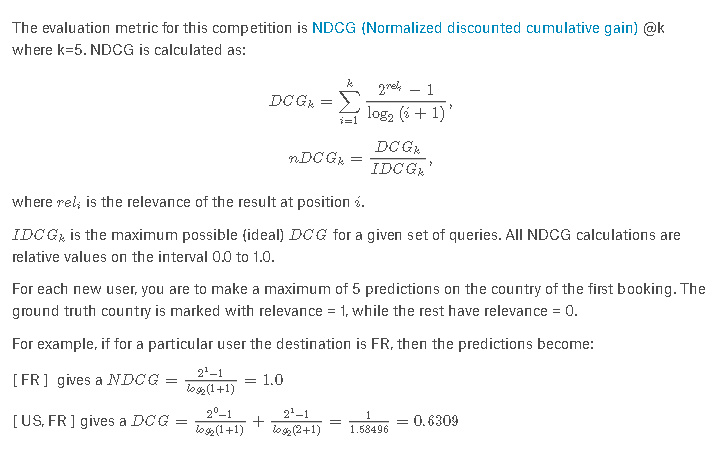

# Define a function to output the NDCG score based on the model, feature dataset and label dataset:

In [356]:
def funct_NDCG_score_output(logistic_classification_model_input, training_data_features, training_data_labels):
    #Create NDCG function here for computing the NDCG Score:
    def func_NDCG(ranking_number):
        if ranking_number<=5:
            score=(2**1-1)/np.log2(ranking_number+1)
        else:
            score=0
        return score
    
    # Output the classification probability for the top 5 destination countries per user:
    
    ordered_label=logistic_classification_model_input.classes_
    #Create a dictionary of label classes:

    i=0
    label_order_dict=dict()

    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1

    #Create a dataframe for classification probability

    df_prob=pd.DataFrame()

    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*logistic_classification_model_input.predict_proba(training_data_features)))[probability_order]

    df_prob.set_index(training_data_features.index, inplace=True) 

    df_prob=df_prob.rename(columns={'index':'id'})

    df_prob=df_prob.reset_index()

    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)



    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    # Output the classification model prediction class
    
    
    ordered_label1=logistic_classification_model_input.classes_
    
    multinary_classification_prediction_label=logistic_classification_model_input.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    
    # Merge the country prediction rank along with the actual label into the final data frame for computing the NDCG score based on the country ranking:
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability=df_prob_melt_top5_countries.groupby('id')['Probability'].rank(ascending=False)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df=pd.DataFrame(Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df.rename(columns={'Probability': 'Rank'}, inplace=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=pd.merge(df_prob_melt_top5_countries, Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df, left_index=True, right_index=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=Multinary_Logistic_Regression_prediction_probability_df_with_ranking.rename(columns={'variable':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=training_data_labels.reset_index()
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'label':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'country_destination':'country'})
    
    Multinary_Logistic_Regression_prediction_evaludation_df=pd.merge(Multinary_Logistic_Regression_prediction_actual_label_df1, Multinary_Logistic_Regression_prediction_probability_df_with_ranking, how='left', right_on=['id', 'country'],left_on=['id', 'country'])
    
    #Compute the score:
    Multinary_Logistic_Regression_prediction_evaludation_df['Score']=Multinary_Logistic_Regression_prediction_evaludation_df['Rank'].apply(func_NDCG)
    
    
    return Multinary_Logistic_Regression_prediction_evaludation_df

# Leverage the function to evaluate the performance on the training set:

In [367]:
logistic_regression_evaluation_final_df=funct_NDCG_score_output(Multinary_Logistic_Regression, X_train, y_train)

In [359]:
logistic_regression_evaluation_final_df.head()

,id,country,Probability,Rank,Score
0,gevm0ie1gh,ES,NaN,NaN,0.0
1,jhwcf2xu24,CA,NaN,NaN,0.0
2,zey76oxl0y,US,0.870585,1.0,1.0
3,b2x4yqliof,NDF,0.982918,1.0,1.0
4,uro59va61h,US,0.391006,1.0,1.0


In the training data set, the prediction model is doing very poorly for countries like AU, CA, PT, NT, DE, ES and GB. The prediction is very powerful to predict the user that has not done any booking and the users that have booked US as their first destination country.

In [364]:
logistic_regression_evaluation_final_df.groupby('country')['Score'].mean()

country
AU       0.000000
CA       0.000000
DE       0.000969
ES       0.000942
FR       0.436927
GB       0.001019
IT       0.386682
NDF      0.993171
NL       0.000000
PT       0.000000
US       0.871734
other    0.525719
Name: Score, dtype: float64

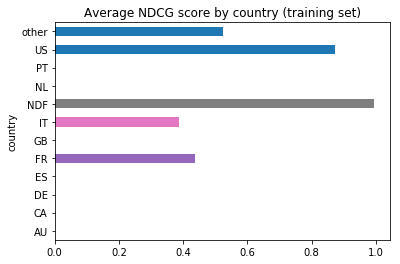

In [363]:
logistic_regression_evaluation_final_df.groupby('country')['Score'].mean().plot(kind='barh', title='Average NDCG score by country (training set)')

# Leverage the function to evaluate the performance on the testing set:

Same as the performance in the training dataset, the prediction model is doing very poorly for countries like AU, CA, PT, NT, DE, ES and GB. The prediction is very powerful to predict the user that has not done any booking and the users that have booked US as their first destination country in the testing dataset.

In [366]:
logistic_regression_evaluation_final_df_testing=funct_NDCG_score_output(Multinary_Logistic_Regression, X_test, y_test)

In [368]:
logistic_regression_evaluation_final_df_testing.groupby('country')['Score'].mean()

country
AU       0.000000
CA       0.000000
DE       0.001985
ES       0.000000
FR       0.436112
GB       0.000000
IT       0.386180
NDF      0.993069
NL       0.000000
PT       0.000000
US       0.875352
other    0.525819
Name: Score, dtype: float64

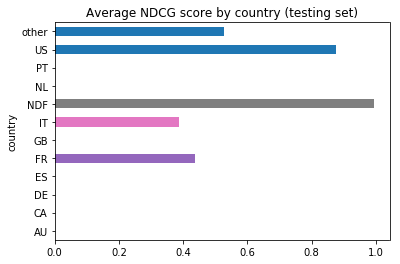

In [369]:
logistic_regression_evaluation_final_df_testing.groupby('country')['Score'].mean().plot(kind='barh', title='Average NDCG score by country (testing set)')

# Use Random Forest to train the model: 

# Need to review before getting started:
Random Forest output probability:

https://www.linkedin.com/pulse/decoding-probabilities-random-forest-sanchit-tiwari/